In [1]:
import os,sys
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/opt/cuda-11.1 --xla_gpu_strict_conv_algorithm_picker=false"
sys.path.append('/opt/cuda-11.1/bin')

os.environ['LD_LIBRARY_PATH'] = '/opt/cuda-11.1/bin'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'


In [2]:
import jax
import flax
from jax import numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler


sys.path.append('../jtils')
sys.path.append('../diffusions')

from jtils.batch_ops import batch_mul, batch_add
from jtils.datasets.two_dim import load_twodim
from jtils.datasets.tf.datasets import load_tfds
from jtils.plot import plot_img, plot_2d


from diffusions.training import get_loss_fn, get_step_fn, init_training_state, optimization_manager
from diffusions.model_ioputs import DiffusionModelInput, ModelConfig
from diffusions.diffusion_spec.discrete_ou import DiscreteOU
from diffusions.models.mlp import MLPNet
from diffusions.models.conv_unet import ConvUnet
from diffusions.model_utils import get_model_fn

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


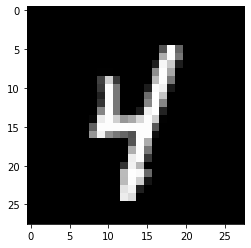

In [4]:
ds = load_tfds('mnist', data_dir='../data').repeat()
batch_size = 128
per_device_batch_size = batch_size // jax.device_count()
batch_dims = [jax.local_device_count(), per_device_batch_size]
for batch_size in reversed(batch_dims):
    ds = ds.batch(batch_size, drop_remainder=True)

def process_fn(i):
    return {'x_0': i['image'] / 255}

ds = ds.map(process_fn)
ds_iter = iter(ds)

batch = next(ds_iter)
plot_img(batch['x_0'][0,0].numpy(), cmap='gray')
plt.show()

In [5]:
# Model to train, dependent on data modality
rng = jax.random.PRNGKey(0)
model_config = ModelConfig(embed_dim=256, channels=(32, 64, 128, 256))
model = ConvUnet(model_config)

In [6]:
# Forward backward diffusion specification, most of the customisation
# - forward_sample
# - pointwise_loss
# - simulate_reverse_diffusion
sde = DiscreteOU(N=100)

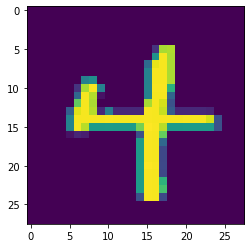

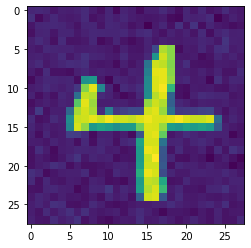

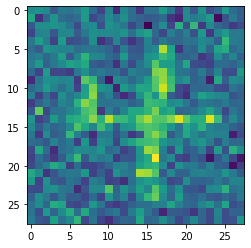

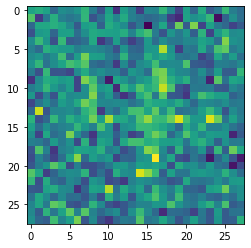

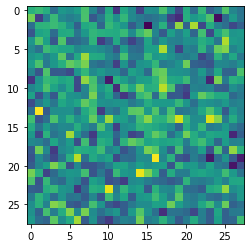

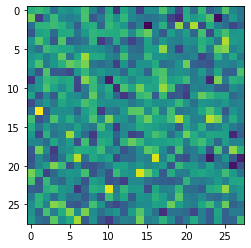

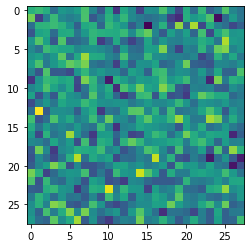

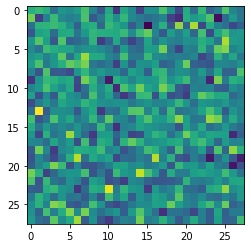

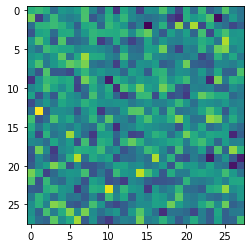

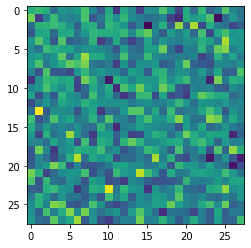

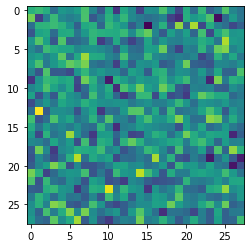

In [7]:
x_0 = next(ds_iter)['x_0'][0,0].numpy()

plot_img(x_0)
plt.show()
        
        
for t in range(sde.N):
    if t % 10 == 0:
        t = t * jnp.ones((x_0.shape[0],), dtype=jnp.int32)
        x_t = sde.sample_x(rng, x_0, t).x_t
        plot_img(x_t)
        plt.show()
        

In [8]:
optimize_fn = optimization_manager(warmup=100, grad_clip=1.)
train_state = init_training_state(rng=rng, 
                        model=model,
                        input_shapes={'x_t':[1,28,28,1], 't':[1]},
                        optimizer=flax.optim.Adam(),
                        lr=1e-4,
                        ema_rate=0.999)

In [9]:
def train(train_state, model, sde, optimize_fn, num_iter=5*10**3, seed=0):
    rng = jax.random.PRNGKey(seed)
    step_fn = get_step_fn(model, sde, optimize_fn)
    p_step_fn = jax.pmap(step_fn, axis_name='batch')

    pstate = flax.jax_utils.replicate(train_state)
    
    for it in range(num_iter):
        batch = next(ds_iter)
        batch = jax.tree_map(lambda x: x.numpy(), batch)

        rng, *next_rng = jax.random.split(rng, num=jax.local_device_count() + 1)
        next_rng = jnp.asarray(next_rng)
        carry_state = (next_rng, pstate)
        (_, pstate), ploss = p_step_fn(carry_state, batch)

        if it%10**3==0:
            print(it, ploss)
            
    return flax.jax_utils.unreplicate(pstate)

In [10]:
state = train_state

In [11]:
state = train(state, model, sde, optimize_fn, num_iter=3*10**4)

0 [0.7107254]
1000 [0.04384772]
2000 [0.03174528]
3000 [0.01926798]
4000 [0.02931161]
5000 [0.02591152]
6000 [0.02285112]
7000 [0.02204935]
8000 [0.01998603]
9000 [0.0225575]
10000 [0.02205768]
11000 [0.01579796]
12000 [0.017579]
13000 [0.01626958]
14000 [0.02512994]
15000 [0.0185196]
16000 [0.02106973]
17000 [0.01675509]
18000 [0.016174]
19000 [0.0189372]
20000 [0.02143406]
21000 [0.0211667]
22000 [0.02113426]
23000 [0.01841551]
24000 [0.01640653]
25000 [0.01838941]
26000 [0.01757482]
27000 [0.01784884]
28000 [0.01785166]
29000 [0.01697063]


In [12]:
model_fn = get_model_fn(model, state.ema_params)
backward_fn = sde.get_simulate_reverse_diffusion_fn(model_fn)

x_T = jax.random.normal(rng, (16,28,28,1))
out = backward_fn(rng, x_T)

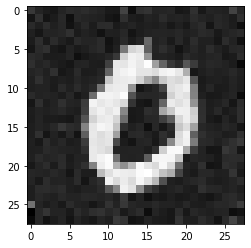

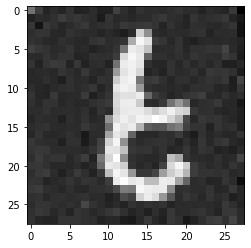

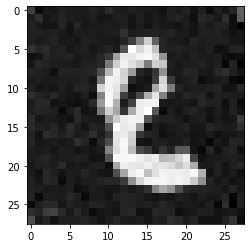

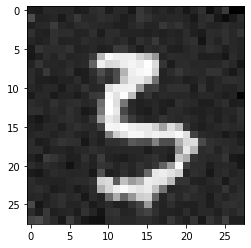

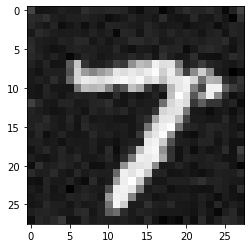

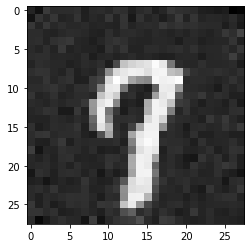

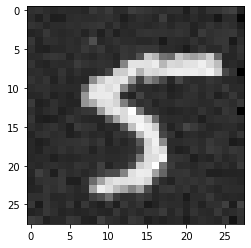

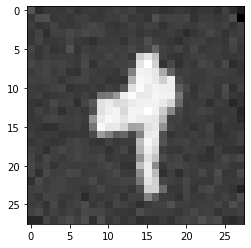

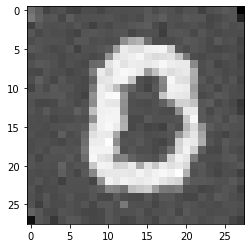

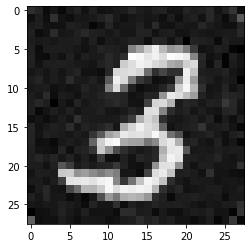

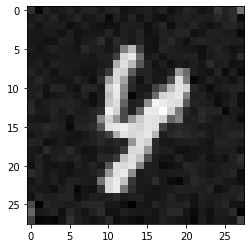

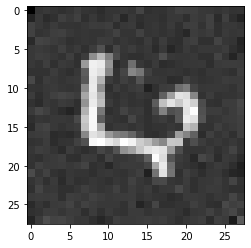

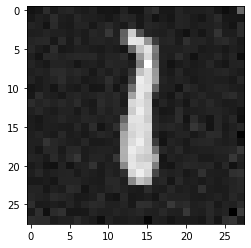

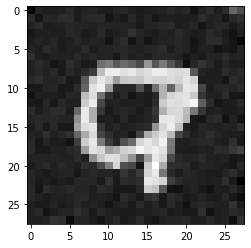

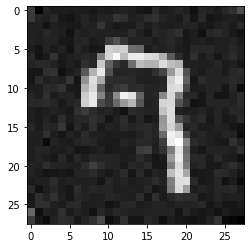

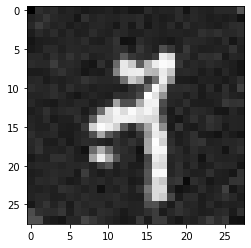

In [13]:
for i in range(16):
    plot_img(out[0][i], cmap='gray')
    plt.show()